In [2]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

from sklearn.model_selection import train_test_split, KFold

2025-12-02 11:47:39.072928: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-02 11:47:39.602520: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-02 11:47:39.638920: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-12-02 11:47:39.638949: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

# 1.Load Dataset

In [3]:
data_dir = "/home/aurore/code/afallo/brain_tumor_detection_project/raw_data/classification_binaire/"


In [4]:
img = load_img(f"{data_dir}notumor/Tr-no_0010.jpg")
x = img_to_array(img)/255  # We divide the pixel value by 255 to end up between 0 and 1

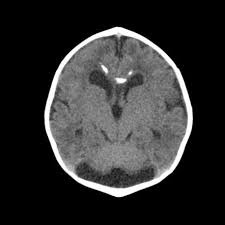

In [5]:
img

In [6]:
x.shape

(225, 225, 3)

## 1.1 Dataframe creation with images paths and label



In [7]:
def path_df(tr_path):
    classes = []
    class_paths = []

    for label in os.listdir(tr_path):
        folder = os.path.join(tr_path, label)
        if os.path.isdir(folder):
            for image in os.listdir(folder):
                classes.append(label)
                class_paths.append(os.path.join(folder, image))

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df


In [8]:
df = path_df(data_dir)

In [9]:
df


,Class Path,Class
0,/home/aurore/code/afallo/brain_tumor_detection...,tumor
1,/home/aurore/code/afallo/brain_tumor_detection...,tumor
2,/home/aurore/code/afallo/brain_tumor_detection...,tumor
3,/home/aurore/code/afallo/brain_tumor_detection...,tumor
4,/home/aurore/code/afallo/brain_tumor_detection...,tumor
...,...,...
18610,/home/aurore/code/afallo/brain_tumor_detection...,notumor
18611,/home/aurore/code/afallo/brain_tumor_detection...,notumor
18612,/home/aurore/code/afallo/brain_tumor_detection...,notumor
18613,/home/aurore/code/afallo/brain_tumor_detection...,notumor


In [10]:
!pip install ImageHash

In [11]:
import pandas as pd
from PIL import Image
import imagehash

# Exemple : ton DataFrame contient une colonne 'path'
# df = pd.DataFrame({"path": ["img1.jpg", "img2.jpg", ...]})

def compute_phash(img_path):
    try:
        img = Image.open(img_path)
        return imagehash.phash(img)
    except Exception as e:
        #print(f"Erreur avec {img_path}: {e}")
        return None

# Calcul du pHash pour chaque image
df["phash"] = df["Class Path"].apply(compute_phash)

# Détection des duplicats exacts (même hash)
duplicates = df[df.duplicated("phash", keep=False)].sort_values("phash")

print("Duplicats détectés :")
print(duplicates)


TypeError: '<' not supported between instances of 'ImageHash' and 'ImageHash'

In [ ]:
# Détection des quasi-duplicats (distance de Hamming < seuil)
def is_near_duplicate(hash1, hash2, threshold=5):
    if hash1 is None or hash2 is None:
        return False
    return abs(hash1 - hash2) < threshold

# Exemple : comparer toutes les paires (attention O(n^2), à optimiser si dataset gros)
near_duplicates = []
paths = df["Class Path"].tolist()
hashes = df["phash"].tolist()

for i in range(len(paths)):
    for j in range(i+1, len(paths)):
        if is_near_duplicate(hashes[i], hashes[j], threshold=5):
            near_duplicates.append((paths[i], paths[j]))

print("Quasi-duplicats détectés :")
for dup in near_duplicates:
    print(dup)

In [ ]:
from pathlib import Path
import hashlib
import os

# --- Paramès ---
DATASET_ROOT = Path("../raw_data/classification_binaire")  # dossier racine contenant Training/ et Testing/
CLASSES = ["tumor", "notumor"]
# SPLITS_ORDER = ["Training", "Testing"]  # Priorité : on garde ce qu'on voit en premier
EXTENSIONS = (".jpg", ".jpeg", ".png", ".bmp")  # adapte si besoin
DRY_RUN = True  # Mettre False pour réellement supprimer les fichiers

# ----------------------------

def file_hash(path, algo="md5", block_size=65536):
    """Hash du fichier basé sur son contenu (rapide et robuste pour duplicats exacts)."""
    h = hashlib.new(algo)
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(block_size), b""):
            h.update(chunk)
    return h.hexdigest()


def list_all_images():
    """Retourne la liste de tous les chemins d’images (Training + Testing, toutes classes)."""
    all_paths = []
    #for split in SPLITS_ORDER:  # Training d'abord, puis Testing
    for cls in CLASSES:
        folder = DATASET_ROOT/ cls
        if not folder.exists():
            print(f"⚠️ Dossier absent : {folder}")
            continue
        for ext in EXTENSIONS:
            all_paths.extend(folder.rglob(f"*{ext}"))
    return all_paths


def find_duplicates(paths):
    """
    Retourne:
        - hash_to_files: dict hash -> [liste des fichiers]
        - duplicates: liste de listes [fichier_à_garder, fichier_dup1, fichier_dup2, ...]
    """
    hash_to_files = {}
    for i, p in enumerate(paths, 1):
        if i % 500 == 0:
            print(f"Scanné {i} fichiers...")
        h = file_hash(p)
        hash_to_files.setdefault(h, []).append(p)

    duplicates_groups = []
    for h, files in hash_to_files.items():
        if len(files) > 1:
            # garder le premier (selon ordre SPLITS_ORDER)
            keep = files[0]
            dups = files[1:]
            duplicates_groups.append([keep] + dups)

    return hash_to_files, duplicates_groups


def main():
    print("🔍 Listing des images...")
    all_paths = list_all_images()
    print(f"Total d'images trouvées : {len(all_paths)}")

    print("🧮 Calcul des hash et recherche des doublons...")
    _, duplicates_groups = find_duplicates(all_paths)

    if not duplicates_groups:
        print("✅ Aucun doublon exact trouvé.")
        return

    total_dups = sum(len(g) - 1 for g in duplicates_groups)
    print(f"⚠️ Nombre de groupes de doublons : {len(duplicates_groups)}")
    print(f"⚠️ Nombre total de fichiers en trop : {total_dups}\n")

    # Afficher un aperçu
    print("Exemple de groupe de doublons :")
    for g in duplicates_groups[:3]:  # maximum 3 groupes affichés
        print("  À garder :", g[0])
        for d in g[1:]:
            print("    Doublon :", d)
        print()

    if DRY_RUN:
        print("Mode DRY_RUN = True : aucun fichier ne sera supprimé.")
        print("Si tout te semble OK, passe DRY_RUN à False et relance.")
        return

    # Suppression effective
    print("🗑 Suppression des doublons...")
    deleted = 0
    for group in duplicates_groups:
        to_delete = group[1:]  # on garde group[0]
        for f in to_delete:
            try:
                os.remove(f)
                deleted += 1
            except Exception as e:
                print(f"Erreur en supprimant {f}: {e}")

    print(f"✅ Suppression terminée. Fichiers supprimés : {deleted}")


# if __name__ == "__main__":
main()

🔍 Listing des images...
Total d'images trouvées : 9023
🧮 Calcul des hash et recherche des doublons...
Scanné 500 fichiers...
Scanné 1000 fichiers...
Scanné 1500 fichiers...
Scanné 2000 fichiers...
Scanné 2500 fichiers...
Scanné 3000 fichiers...
Scanné 3500 fichiers...
Scanné 4000 fichiers...
Scanné 4500 fichiers...
Scanné 5000 fichiers...
Scanné 5500 fichiers...
Scanné 6000 fichiers...
Scanné 6500 fichiers...
Scanné 7000 fichiers...
Scanné 7500 fichiers...
Scanné 8000 fichiers...
Scanné 8500 fichiers...
Scanné 9000 fichiers...
✅ Aucun doublon exact trouvé.


# 2.Train val test split

In [12]:
test_df, train_df = train_test_split(df, train_size=0.2, stratify=df['Class'])

In [13]:
val_df, train_df = train_test_split(train_df, train_size=0.3, stratify=train_df['Class'])

# 3.Preprocess

In [14]:
batch_size = 32
img_size = (225, 225)

scale = ImageDataGenerator(rescale=1/255)
scale_gen = ImageDataGenerator(rescale=1/255, brightness_range=(0.8,1.2))

train_scale_gen = scale_gen.flow_from_dataframe(train_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size, class_mode="binary")

train_scale = scale.flow_from_dataframe(train_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size, class_mode="binary")

val_scale_gen = scale_gen.flow_from_dataframe(val_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size, class_mode="binary")


val_scale = scale.flow_from_dataframe(val_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size, class_mode="binary")

test_scale = scale.flow_from_dataframe(test_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size, class_mode="binary", shuffle = False)

Found 5023 validated image filenames belonging to 2 classes.


Found 5023 validated image filenames belonging to 2 classes.
Found 2187 validated image filenames belonging to 2 classes.
Found 2187 validated image filenames belonging to 2 classes.
Found 1813 validated image filenames belonging to 2 classes.


/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 5402 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 5402 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 2280 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 2280 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs

In [ ]:
len(train_df)

7997

# 4.Base Model

In [15]:
def initialize_model():

    model = Sequential()
    model.add(Input(shape=(225, 225, 3)))

    ### First Convolution & MaxPooling
    model.add(layers.Conv2D(8, (4, 4), padding ='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    ### Second Convolution & MaxPooling
    #model.add(layers.Conv2D(16, (3, 3), activation="relu"))
    #model.add(layers.MaxPool2D(pool_size=(2, 2)))

    ### Flattening
    model.add(layers.Flatten())

    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(layers.Dense(5, activation='relu'))

    ### Last layer - Classification Layer with 10 outputs corresponding to 10 digits
    model.add(layers.Dense(1, activation='sigmoid'))

    ### Model compilation
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', Recall(), Precision()])
    return model

In [16]:
model = initialize_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 225, 225, 8)       392       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 8)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 5)                 501765    
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 


2025-12-02 11:49:55.978195: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-12-02 11:49:55.978401: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-12-02 11:49:55.978538: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (MSI): /proc/driver/nvidia/version does not exist
2025-12-02 11:49:55.979545: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Total params: 502,163
Trainable params: 502,163
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(patience = 5, restore_best_weights=True )
history = model.fit(train_scale,
                 epochs=20,
                 validation_data=val_scale,
                 callbacks = [es])

Epoch 1/20
158/158 [==============================] - 11s 70ms/step - loss: 0.6042 - accuracy: 0.7569 - recall_2: 0.7703 - precision_2: 0.7838 - val_loss: 0.4912 - val_accuracy: 0.8262 - val_recall_2: 0.7368 - val_precision_2: 0.9294
Epoch 2/20
158/158 [==============================] - 7s 46ms/step - loss: 0.4582 - accuracy: 0.8923 - recall_2: 0.8873 - precision_2: 0.9143 - val_loss: 0.4252 - val_accuracy: 0.9240 - val_recall_2: 0.9073 - val_precision_2: 0.9510
Epoch 3/20
158/158 [==============================] - 7s 46ms/step - loss: 0.4035 - accuracy: 0.9137 - recall_2: 0.9157 - precision_2: 0.9264 - val_loss: 0.3681 - val_accuracy: 0.9440 - val_recall_2: 0.9566 - val_precision_2: 0.9416
Epoch 4/20
158/158 [==============================] - 7s 46ms/step - loss: 0.3449 - accuracy: 0.9452 - recall_2: 0.9510 - precision_2: 0.9493 - val_loss: 0.3302 - val_accuracy: 0.9527 - val_recall_2: 0.9591 - val_precision_2: 0.9543
Epoch 5/20
158/158 [==============================] - 7s 46ms/step 

In [17]:
def plot_history(history):

    fig, ax = plt.subplots(4, 1, figsize=(8,13))

    ax[0].set_title('loss')

    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")

    ax[1].set_title('Accuracy')

    ax[1].plot(history.epoch, history.history["accuracy"], label="Train Accuracy")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy")


    ax[2].set_title('Recall')

    ax[2].plot(history.epoch, history.history["recall_2"], label="Train recall")
    ax[2].plot(history.epoch, history.history["val_recall_2"], label="Validation recall")

    ax[3].set_title('Precision')

    ax[3].plot(history.epoch, history.history["precision_2"], label="precision")
    ax[3].plot(history.epoch, history.history["val_precision_2"], label="Validation precision")


    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[3].legend()

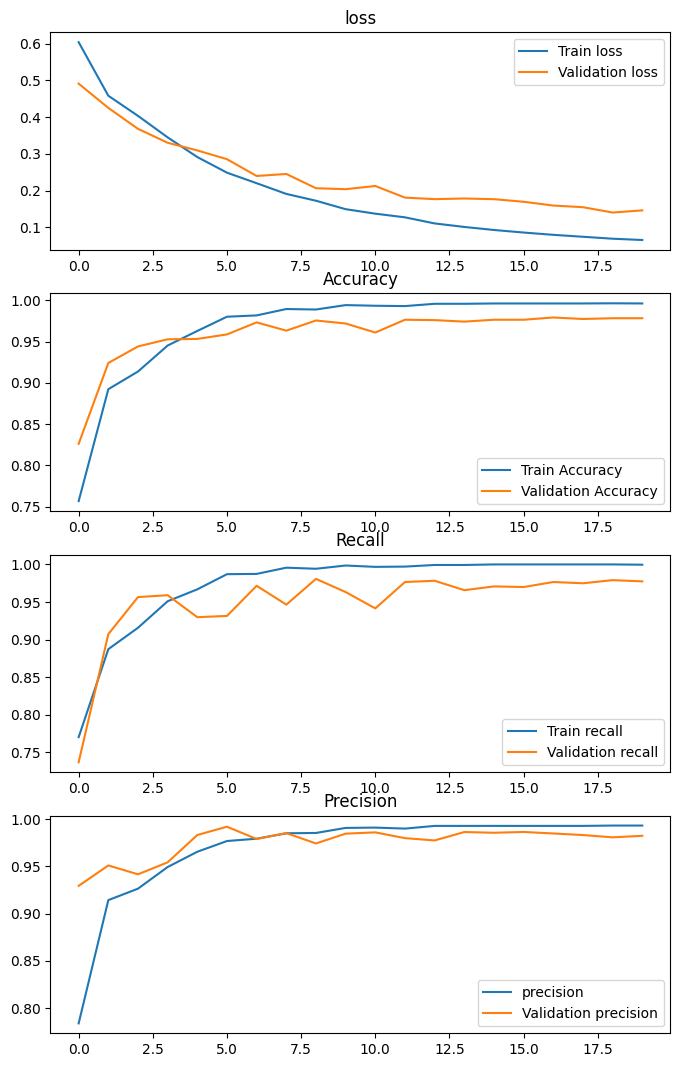

In [ ]:

plot_history(history)


In [ ]:
model.evaluate(test_scale)

57/57 [==============================] - 2s 27ms/step - loss: 0.0403 - accuracy: 0.9867 - recall: 0.9898 - precision: 0.9857


[0.040265120565891266,
 0.9866962432861328,
 0.9897645711898804,
 0.9857288599014282]

In [ ]:
predictions = model.predict(test_scale, steps=len(test_scale))

57/57 [==============================] - 2s 27ms/step


In [ ]:
y_pred = (predictions > 0.5).astype(int).ravel()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_scale.classes, y_pred)


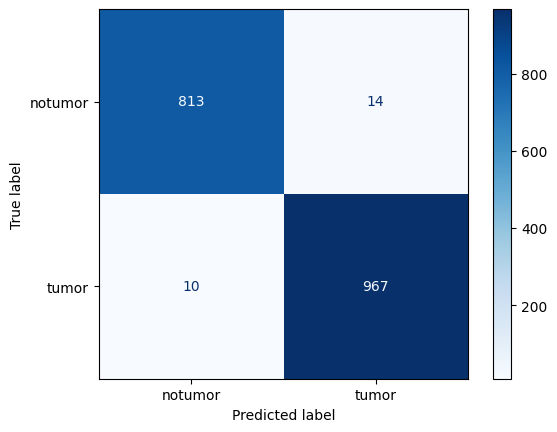

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_scale.class_indices.keys())
disp.plot(cmap='Blues')


In [ ]:
predictions

array([[9.9951607e-01],
       [9.9859762e-01],
       [4.5409281e-09],
       ...,
       [9.9899709e-01],
       [3.1977844e-01],
       [2.8738079e-03]], dtype=float32)

In [18]:
test_df, train_val_df = train_test_split(df, train_size=0.2, stratify=df['Class'])

In [20]:
%%time

kf = KFold(n_splits=5)
kf.get_n_splits(train_df)

results = []
es = EarlyStopping(patience = 5, restore_best_weights=True )

for train_index, test_index in kf.split(train_df):
#     # Split the data into train and test

    train_df, val_df = train_val_df.iloc[train_index], train_val_df.iloc[test_index]

#     # Scaling your data


    train_scale_gen = scale_gen.flow_from_dataframe(train_df, x_col='Class Path',
                                    y_col='Class', batch_size=batch_size,
                                    target_size=img_size, class_mode="binary")

    train_scale = scale.flow_from_dataframe(train_df, x_col='Class Path',
                                    y_col='Class', batch_size=batch_size,
                                    target_size=img_size, class_mode="binary")

    val_scale_gen = scale_gen.flow_from_dataframe(val_df, x_col='Class Path',
                                        y_col='Class', batch_size=batch_size,
                                        target_size=img_size, class_mode="binary")


    val_scale = scale.flow_from_dataframe(val_df, x_col='Class Path',
                                        y_col='Class', batch_size=batch_size,
                                        target_size=img_size, class_mode="binary")


    # 3. Model
    model = initialize_model()
    history = model.fit(train_scale,
                 epochs=20,
                 validation_data=val_scale,
                 callbacks = [es])

    # 4. Evaluation

    results.append(model.evaluate(val_scale))

Found 3249 validated image filenames belonging to 2 classes.


Found 3249 validated image filenames belonging to 2 classes.
Found 802 validated image filenames belonging to 2 classes.
Found 802 validated image filenames belonging to 2 classes.


/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 3423 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 3423 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 866 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 866 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/20
102/102 [==============================] - 9s 73ms/step - loss: 0.5630 - accuracy: 0.7929 - recall_2: 0.8398 - precision_2: 0.7898 - val_loss: 0.4841 - val_accuracy: 0.8716 - val_recall_2: 0.8500 - val_precision_2: 0.9100
Epoch 2/20
102/102 [==============================] - 7s 69ms/step - loss: 0.4644 - accuracy: 0.8852 - recall_2: 0.8860 - precision_2: 0.8998 - val_loss: 0.4348 - val_accuracy: 0.9127 - val_recall_2: 0.8955 - val_precision_2: 0.9426
Epoch 3/20
102/102 [==============================] - 7s 70ms/step - loss: 0.3921 - accuracy: 0.9388 - recall_2: 0.9299 - precision_2: 0.9555 - val_loss: 0.4101 - val_accuracy: 0.9015 - val_recall_2: 0.8545 - val_precision_2: 0.9616
Epoch 4/20
102/102 [==============================] - 7s 71ms/step - loss: 0.3458 - accuracy: 0.9575 - recall_2: 0.9515 - precision_2: 0.9692 - val_loss: 0.3741 - val_accuracy: 0.9252 - val_recall_2: 0.8864 - val_precision_2: 0.9750
Epoch 5/20
102/102 [==============================] - 7s 69ms/step -

/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 3406 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 3406 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 883 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 883 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/20
103/103 [==============================] - 8s 78ms/step - loss: 0.3768 - accuracy: 0.8463 - recall_3: 0.8319 - precision_3: 0.8767 - val_loss: 0.2285 - val_accuracy: 0.9261 - val_recall_3: 0.9400 - val_precision_3: 0.9271
Epoch 2/20
103/103 [==============================] - 9s 85ms/step - loss: 0.1542 - accuracy: 0.9513 - recall_3: 0.9466 - precision_3: 0.9625 - val_loss: 0.3020 - val_accuracy: 0.8866 - val_recall_3: 0.9769 - val_precision_3: 0.8426
Epoch 3/20
103/103 [==============================] - 9s 88ms/step - loss: 0.1013 - accuracy: 0.9694 - recall_3: 0.9676 - precision_3: 0.9754 - val_loss: 0.1704 - val_accuracy: 0.9401 - val_recall_3: 0.9515 - val_precision_3: 0.9406
Epoch 4/20
103/103 [==============================] - 9s 88ms/step - loss: 0.0595 - accuracy: 0.9825 - recall_3: 0.9801 - precision_3: 0.9874 - val_loss: 0.1547 - val_accuracy: 0.9516 - val_recall_3: 0.9561 - val_precision_3: 0.9561
Epoch 5/20
103/103 [==============================] - 10s 93ms/step 

/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 3412 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 3412 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 877 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 877 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(


102/102 [==============================] - 7s 69ms/step - loss: 0.7035 - accuracy: 0.5365 - recall_4: 0.9573 - precision_4: 0.5393 - val_loss: 0.6917 - val_accuracy: 0.5537 - val_recall_4: 1.0000 - val_precision_4: 0.5537
Epoch 2/20
102/102 [==============================] - 7s 73ms/step - loss: 0.6917 - accuracy: 0.5387 - recall_4: 1.0000 - precision_4: 0.5387 - val_loss: 0.6905 - val_accuracy: 0.5537 - val_recall_4: 1.0000 - val_precision_4: 0.5537
Epoch 3/20
102/102 [==============================] - 7s 67ms/step - loss: 0.6911 - accuracy: 0.5387 - recall_4: 1.0000 - precision_4: 0.5387 - val_loss: 0.6897 - val_accuracy: 0.5537 - val_recall_4: 1.0000 - val_precision_4: 0.5537
Epoch 4/20
102/102 [==============================] - 7s 67ms/step - loss: 0.6907 - accuracy: 0.5387 - recall_4: 1.0000 - precision_4: 0.5387 - val_loss: 0.6891 - val_accuracy: 0.5537 - val_recall_4: 1.0000 - val_precision_4: 0.5537
Epoch 5/20
102/102 [==============================] - 7s 67ms/step - loss: 0.69

/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 3422 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 3422 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 867 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 867 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/20
102/102 [==============================] - 8s 73ms/step - loss: 0.4685 - accuracy: 0.8123 - recall_5: 0.7910 - precision_5: 0.8520 - val_loss: 0.2456 - val_accuracy: 0.9151 - val_recall_5: 0.9215 - val_precision_5: 0.9215
Epoch 2/20
102/102 [==============================] - 7s 70ms/step - loss: 0.2011 - accuracy: 0.9409 - recall_5: 0.9443 - precision_5: 0.9465 - val_loss: 0.1764 - val_accuracy: 0.9426 - val_recall_5: 0.9515 - val_precision_5: 0.9428
Epoch 3/20
102/102 [==============================] - 7s 68ms/step - loss: 0.1204 - accuracy: 0.9625 - recall_5: 0.9642 - precision_5: 0.9664 - val_loss: 0.1440 - val_accuracy: 0.9638 - val_recall_5: 0.9677 - val_precision_5: 0.9654
Epoch 4/20
102/102 [==============================] - 7s 70ms/step - loss: 0.0732 - accuracy: 0.9818 - recall_5: 0.9824 - precision_5: 0.9841 - val_loss: 0.1484 - val_accuracy: 0.9526 - val_recall_5: 0.9769 - val_precision_5: 0.9379
Epoch 5/20
102/102 [==============================] - 7s 70ms/step -

/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 3493 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 3493 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 796 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 796 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/20
100/100 [==============================] - 8s 71ms/step - loss: 0.5504 - accuracy: 0.7770 - recall_6: 0.9065 - precision_6: 0.7433 - val_loss: 0.4908 - val_accuracy: 0.8016 - val_recall_6: 0.9044 - val_precision_6: 0.7579
Epoch 2/20
100/100 [==============================] - 7s 69ms/step - loss: 0.4105 - accuracy: 0.8937 - recall_6: 0.9192 - precision_6: 0.8906 - val_loss: 0.4319 - val_accuracy: 0.9002 - val_recall_6: 0.8733 - val_precision_6: 0.9291
Epoch 3/20
100/100 [==============================] - 7s 71ms/step - loss: 0.3575 - accuracy: 0.9226 - recall_6: 0.9289 - precision_6: 0.9300 - val_loss: 0.4354 - val_accuracy: 0.8658 - val_recall_6: 0.9200 - val_precision_6: 0.8364
Epoch 4/20
100/100 [==============================] - 7s 70ms/step - loss: 0.3141 - accuracy: 0.9415 - recall_6: 0.9461 - precision_6: 0.9472 - val_loss: 0.3768 - val_accuracy: 0.9163 - val_recall_6: 0.8844 - val_precision_6: 0.9499
Epoch 5/20
100/100 [==============================] - 7s 69ms/step -

In [21]:
results

[[0.20017030835151672,
  0.9588528871536255,
  0.9636363387107849,
  0.9614512324333191],
 [0.1539776474237442,
  0.9477707147598267,
  0.9538106322288513,
  0.9516128897666931],
 [0.687840461730957, 0.5537294745445251, 1.0, 0.5537294745445251],
 [0.12851005792617798,
  0.9675405621528625,
  0.9815242290496826,
  0.9593679308891296],
 [0.34380242228507996,
  0.9346330165863037,
  0.9577777981758118,
  0.9189765453338623]]

In [24]:
accuracy = np.mean(results[:][1])
accuracy

0.7517929710447788

In [25]:
recall = np.mean(results[:][2])
recall

0.6988248527050018

In [26]:
precision = np.mean(results[:][3])
precision

0.7592356950044632